In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [4]:
tfk = tf.keras
tfkl = tf.keras.layers




In [5]:
x, y = make_classification(n_samples=1000, n_features=3, n_informative=2,
                           n_redundant=0, n_repeated=1, n_clusters_per_class=2,
                           random_state=43, n_classes=2)

x.shape, y.shape



((1000, 3), (1000,))

In [6]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)
x_pca.shape



(1000, 2)

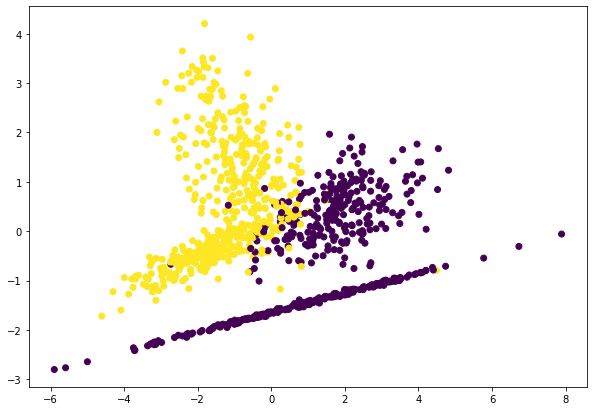

In [7]:
fig = plt.figure(figsize=(10, 7))
plt.scatter(x_pca[:, 0], x_pca[:,1], c=y )
plt.show()


### Train and test split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=.5)


In [9]:
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape



((600, 3), (200, 3), (200, 3), (600,), (200,), (200,))

### GaussianNB


In [10]:
np.random.seed(42)
gnb = GaussianNB()

gnb.fit(x_train, y_train)

y_preds_gnb = gnb.predict_proba(x_test)
y_preds_gnb.shape




(200, 2)

### Simple MLP

In [11]:
encoder = OneHotEncoder(sparse=False)

y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_onehot = encoder.fit_transform(y_val.reshape(-1, 1))
y_test_onehot = encoder.fit_transform(y_test.reshape(-1, 1))




y_train_onehot.shape, y_val_onehot.shape, y_test_onehot.shape

((600, 2), (200, 2), (200, 2))

In [12]:
gnb_roc_auc = roc_auc_score(y_true=y_test_onehot, y_score=y_preds_gnb)
gnb_roc_auc



0.9604841936774711

In [13]:
n_units = 10

model_mlp = tf.keras.Sequential([
    tfkl.Dense(units=n_units, input_shape=(x.shape[1],),
               activation='relu', name="dense1"),
    tfkl.Dense(units=n_units, activation='relu', name="dense2"),
    tfkl.Dense(2)
])



In [14]:
optimizer = tfk.optimizers.Adam(learning_rate=1e-4)



In [15]:
loss = tfk.losses.BinaryCrossentropy(from_logits=True)  # binaryclass
# loss = tfk.losses.CategoricalCrossentropy(from_logits=True)  # multiclass



In [16]:
model_mlp.compile(optimizer=optimizer, loss=loss)



In [ ]:
model_mlp.fit(x=x_train, y=y_train_onehot, validation_data=(x_val, y_val_onehot), 
          epochs=1000, verbose=True)



Epoch 1/1000
19/19 [==============================] - 1s 15ms/step - loss: 0.7920 - val_loss: 0.8027
Epoch 2/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7843 - val_loss: 0.7952
Epoch 3/1000
19/19 [==============================] - 0s 4ms/step - loss: 0.7768 - val_loss: 0.7878
Epoch 4/1000
19/19 [==============================] - 0s 4ms/step - loss: 0.7695 - val_loss: 0.7806
Epoch 5/1000
19/19 [==============================] - 0s 4ms/step - loss: 0.7622 - val_loss: 0.7734
Epoch 6/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7552 - val_loss: 0.7663
Epoch 7/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.7482 - val_loss: 0.7594
Epoch 8/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7413 - val_loss: 0.7527
Epoch 9/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7347 - val_loss: 0.7460
Epoch 10/1000
19/19 [==============================] - 0s 6ms/step - loss: 0.7281 - val_loss: 0.739

In [ ]:
y_preds_mlp = tf.nn.softmax(model_mlp.predict(x_test)).numpy()
y_preds_mlp.shape



In [ ]:
mlp_roc_auc = roc_auc_score(y_true=y_test_onehot, y_score=y_preds_mlp)

mlp_roc_auc



### Other deep ML